## Utilities

In [1]:
import re, glob, math
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pathlib import Path
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from data.preprocessing.preprocess import preprocess_plateaus  # preprocessor
from experiments_xy import (
    collect_dataset_from_combined,   # builds X,y,groups from *_combined.npy
    build_X,                         # shapes features by mode name
)

from utils import (
    _expand_combined_files,
    _bin_series,
    nominal_angle_from_path,
    nominal_from_group,
    split_one_plateau_per_angle_test,
    _find_bin_dirs,
    _load_metrics_for_bin,
    _plot_line,
    angle_deg,
    angle_err_deg,
    mag,
    full_plot_suite
)


# Predictions

[PATH] combined-dir: data/preprocessing/P5_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P5_combined
[PATH] matched files: 6
[LOAD] bin_len=512 (~0.050s): X=(3383, 16), y=(3383, 3), groups=12
[DONE] processed files: 6/6
Using bin: 512 Common bins: [512]
Nominal angles in TEST: [90.0, 135.0, 180.0]


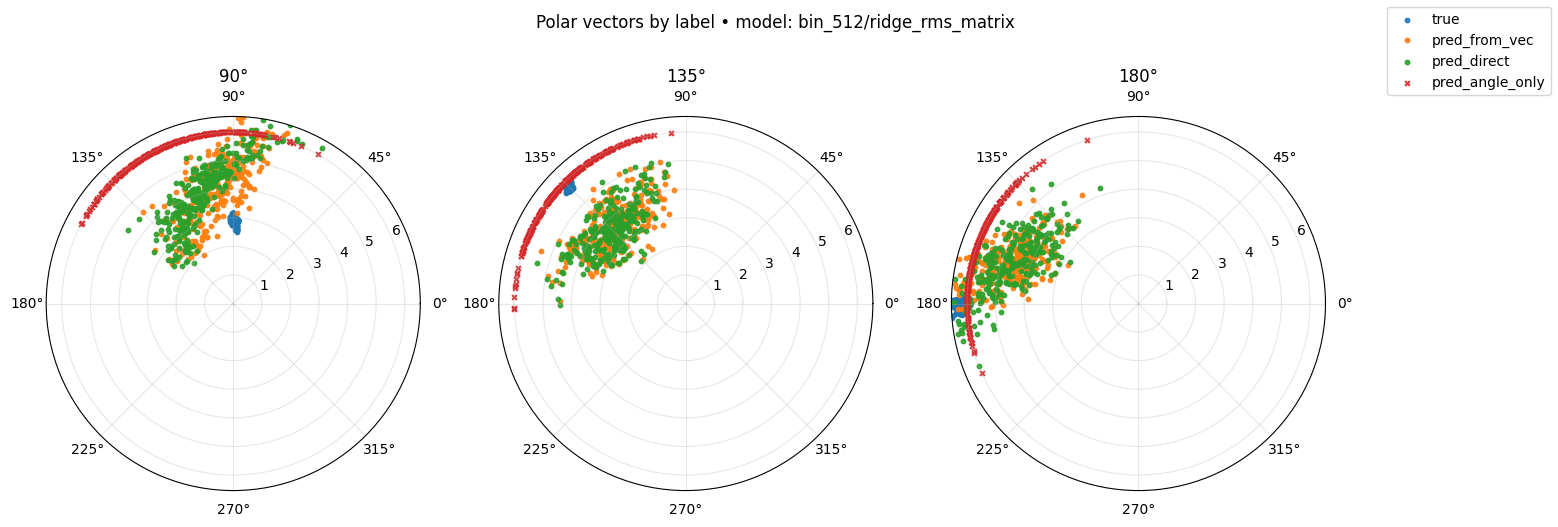

,nominal_deg,n,mae_single_deg,mae_three_vec_deg,mae_three_direct_deg
0,90.0,293,24.052634,15.608979,21.639574
1,135.0,294,12.991948,13.582075,12.595314
2,180.0,292,19.693528,18.700387,20.434698


In [19]:
# --- USER CONFIG (edit these to your run folders) ---
from pathlib import Path
COMBINED_DIR = Path("data/preprocessing/P5_combined")         # where *_combined.npy live
RESULTS_ROOT_SINGLE = Path("results_feat/P5_angle_only")      # run trained with y = [Angle]
RESULTS_ROOT_THREE  = Path("results_feat/P5_angle")           # run trained with y = [Fx, Fy, Angle]
RMS_WIN = 100
RANDOM_STATE = 42

MODE = "rms_matrix"            # feature mode to use for both models ("rms_matrix" or "all_channels")
BIN_CHOICE = 1024              # set a specific bin (e.g., 512/1024) or None to pick the first common bin

# Polar plot options
RADIUS_FOR_ANGLE_ONLY = 6      # fixed radius for angle-only model (red x)
USE_TRUE_FORCE_RADIUS = True   # True: r_true = ||(Fx,Fy)||; False: use filename mapping
USE_PRED_FORCE_RADIUS = True   # True: r_pred_vec = ||(F̂x,F̂y)||; False: constant
USE_FILENAME_FORCE    = False  # If True, map F1/F2 in filenames -> radius via F_LABEL_TO_RADIUS

F_LABEL_TO_RADIUS = {"F1": 1.0, "F2": 2.0}

# === IMPORTS ===
import re, numpy as np, pandas as pd, joblib, math
import matplotlib.pyplot as plt

from experiments_xy import (
    collect_dataset_from_combined,
    split_one_plateau_per_angle_test,
    build_X,
    nominal_angle_from_path,
)

# === HELPERS ===
def angle_from_fx_fy(fx, fy):
    ang = np.degrees(np.arctan2(fy, fx))
    return np.where(ang < 0, ang + 360.0, ang)

def circ_diff_deg(a_deg, b_deg):
    return (a_deg - b_deg + 180.0) % 360.0 - 180.0

def circ_mae_deg(a_deg, b_deg):
    return float(np.mean(np.abs(circ_diff_deg(a_deg, b_deg))))

def _load_bin_dir(root: Path):
    bins = sorted([p for p in root.glob("bin_*") if p.is_dir()])
    return {int(p.name.split("_",1)[1]): p for p in bins}

def _load_model_and_scaler(bin_dir: Path, mode=MODE):
    model_path = bin_dir / f"ridge_{mode}.joblib"
    y_scaler_path = bin_dir / "y_scaler.joblib"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model: {model_path}")
    model = joblib.load(model_path)
    y_scaler = joblib.load(y_scaler_path) if y_scaler_path.exists() else None
    return model, y_scaler

def _force_label_from_path(p: str) -> str | None:
    base = Path(p).stem
    m = re.search(r'_(F\d+)_', base, flags=re.IGNORECASE)
    return m.group(1).upper() if m else None

# === 1) Build dataset from combined files ===
buckets = collect_dataset_from_combined(
    str(COMBINED_DIR),
    bin_sec=0.050,
    include_angle_target=True,      # keep Fx,Fy,Angle
    rms_win_samples=RMS_WIN,
    modes=(MODE,),
    segment_kind="plateau",
)

# === 2) Pick a common bin ===
bins_single = _load_bin_dir(RESULTS_ROOT_SINGLE)
bins_three  = _load_bin_dir(RESULTS_ROOT_THREE)
common_bins = sorted(set(buckets.keys()) & set(bins_single.keys()) & set(bins_three.keys()))
if not common_bins:
    raise SystemExit("No common bin_* across both results roots and dataset.")
bin_len = BIN_CHOICE if (BIN_CHOICE in common_bins if BIN_CHOICE is not None else False) else common_bins[0]
print("Using bin:", bin_len, "Common bins:", common_bins)

# Dataset for that bin
X = buckets[bin_len]["X"]            # (N,C)
y = buckets[bin_len]["y"]            # (N,3) -> Fx, Fy, Angle
groups = buckets[bin_len]["groups"]  # (N,) strings ".../file.npy::plateauXX"

# === 3) Holdout split identical to training logic ===
train_idx, test_idx, test_groups = split_one_plateau_per_angle_test(groups, rng=RANDOM_STATE)
X_te, y_te, groups_te = X[test_idx], y[test_idx], groups[test_idx]

# Ground-truth angles + radius
angle_true = angle_from_fx_fy(y_te[:,0], y_te[:,1])
r_true_mag = np.hypot(y_te[:,0], y_te[:,1])

if USE_FILENAME_FORCE:
    src_paths = np.array([g.split("::", 1)[0] for g in groups_te])
    f_labels = np.array([_force_label_from_path(p) for p in src_paths])
    r_true = np.array([F_LABEL_TO_RADIUS.get(lbl, np.nan) for lbl in f_labels], float)
else:
    r_true = r_true_mag if USE_TRUE_FORCE_RADIUS else np.ones_like(r_true_mag)

# === 4) Load models & predict ===
bin_dir_single = bins_single[bin_len]
bin_dir_three  = bins_three[bin_len]

model_s, ysc_s = _load_model_and_scaler(bin_dir_single, MODE)  # angle-only run
model_t, ysc_t = _load_model_and_scaler(bin_dir_three,  MODE)  # 3-target run

X_te_feat = build_X(X_te, MODE)  # features matching MODE

pred_s_norm = model_s.predict(X_te_feat)
pred_t_norm = model_t.predict(X_te_feat)

pred_s = ysc_s.inverse_transform(pred_s_norm) if ysc_s is not None else pred_s_norm
pred_t = ysc_t.inverse_transform(pred_t_norm) if ysc_t is not None else pred_t_norm

# angle-only (N,1)
angle_pred_single = pred_s.reshape(-1) if pred_s.shape[1] == 1 else pred_s[:, -1]
r_pred_single = np.full_like(angle_pred_single, RADIUS_FOR_ANGLE_ONLY, dtype=float)

# 3-target heads
if pred_t.shape[1] >= 2:
    # vector head
    angle_pred_vec = angle_from_fx_fy(pred_t[:,0], pred_t[:,1])
    r_pred_vec     = np.hypot(pred_t[:,0], pred_t[:,1]) if USE_PRED_FORCE_RADIUS else np.ones(len(pred_t))
else:
    angle_pred_vec = np.full(len(angle_true), np.nan)
    r_pred_vec     = np.full(len(angle_true), np.nan)

# direct-angle head (use SAME RADIUS as vector head)
angle_pred_three_direct = pred_t[:,2] if pred_t.shape[1] >= 3 else np.full(len(angle_true), np.nan)
angle_pred_three_direct = (angle_pred_three_direct % 360 + 360) % 360  # wrap to [0, 360)
r_pred_three_direct = r_pred_vec.copy()

# === 5) Group test rows by nominal angle & PLOT polar force ===
def _nominal_from_group_label(g: str) -> float:
    return nominal_angle_from_path(g.split("::", 1)[0])

nom_labels = np.array([_nominal_from_group_label(g) for g in groups_te])
unique_noms = np.unique(nom_labels)
print("Nominal angles in TEST:", unique_noms.tolist())

# Determine a sensible rmax across all radii for nice scaling
all_r = []
if not USE_FILENAME_FORCE:
    all_r.extend(r_true[~np.isnan(r_true)])
    if np.isfinite(r_pred_vec).any():
        all_r.extend(r_pred_vec[~np.isnan(r_pred_vec)])
rmax = max(1.0, np.nanpercentile(all_r, 99)) if all_r else 1.0

cols = min(4, len(unique_noms))
rows = int(np.ceil(len(unique_noms) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 5.2*rows),
                         subplot_kw={"projection": "polar"}, squeeze=False)

summary = []
for i, nom in enumerate(unique_noms):
    ax = axes[i//cols, i%cols]
    idxs = np.where(nom_labels == nom)[0]

    # convert to radians
    t_true = np.deg2rad(angle_true[idxs]);              r_t  = r_true[idxs]
    t_s    = np.deg2rad(angle_pred_single[idxs]);       r_s  = r_pred_single[idxs]
    t_tv   = np.deg2rad(angle_pred_vec[idxs]);          r_tv = r_pred_vec[idxs]
    t_td   = np.deg2rad(angle_pred_three_direct[idxs]); r_td = r_pred_three_direct[idxs]  # same radius as vector head

    # scatter
    ax.scatter(t_true, r_t, s=10, label="true", alpha=0.9)
    ax.scatter(t_tv,   r_tv, s=10, label="pred_from_vec", alpha=0.9)
    ax.scatter(t_td,   r_td, s=10, label="pred_direct", alpha=0.9)
    ax.scatter(t_s,    r_s, s=12, label="pred_angle_only", alpha=0.9, marker="x")

    ax.set_title(f"{nom:.0f}°")
    ax.set_rmax(rmax)
    ax.grid(True, alpha=0.3)

    # Circular MAE on angles (r ignored)
    mae_vec   = circ_mae_deg(np.rad2deg(t_tv), np.rad2deg(t_true)) if np.isfinite(t_tv).any() else np.nan
    mae_dir   = circ_mae_deg(np.rad2deg(t_td), np.rad2deg(t_true)) if np.isfinite(t_td).any() else np.nan
    mae_angle = circ_mae_deg(np.rad2deg(t_s),  np.rad2deg(t_true))
    summary.append({"nominal_deg": float(nom), "n": int(len(idxs)),
                    "mae_single_deg": mae_angle, "mae_three_vec_deg": mae_vec, "mae_three_direct_deg": mae_dir})

# Shared legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle(f"Polar vectors by label • model: bin_{bin_len}/ridge_{MODE}", y=0.98)
fig.tight_layout(rect=[0,0,0.88,0.95])
plt.show()

pd.DataFrame(summary).sort_values("nominal_deg")
